<a href="https://colab.research.google.com/github/Amir-Kermanshahani/QML/blob/main/Quanvolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: Quanvolutional Neural Networks: Powering Image Recognition with Quantum Circuits https://arxiv.org/pdf/1904.04767

We can extend the idea of classical Convolutional Networks to the context of quantum variational circuits. A possible approach is given by the following procedure:

1. A small region of the input image, in our example a 2 × 2 square, is embedded into a quantum circuit. In this demo, this is achieved with parametrized rotations applied to the qubits initialized in the ground state.

2. A quantum computation, associated to a unitary U, is performed on the system. The unitary could be generated by a variational quantum circuit or, more simply, by a random circuit as proposed in the reference.

3. The quantum system is finally measured, obtaining a list of classical expectation values. The measurement results could also be classically post-processed, but, for simplicity, in this work we directly use the raw expectation values.

4. Analogously to a classical convolution layer, each expectation value is mapped to a different channel of a single output pixel.

5. Iterating the same procedure over different regions, one can scan the full input image, producing an output object which will be structured as a multi-channel image.

6. The quantum convolution can be followed by further quantum layers or by classical layers.

In this tutorial we follow the approach of the reference in which a fixed non-trainable quantum circuit is used as a “quanvolution” kernel, while the subsequent classical layers are trained for the classification problem of interest. However, by leveraging the ability of PennyLane to evaluate gradients of quantum circuits, the quantum kernel could also be trained.

### General setup

In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

### Setting of the main hyper-parameters of the model

In [5]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "../_static/demonstration_assets/quanvolution/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

### Loading of the MNIST dataset

In [7]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

### Quantum circuit as a convolution kernel

In [8]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

This process halves the resolution of the input image. In the standard language of CNN, this would correspond to a convolution with a 2 × 2 kernel and a stride equal to 2.

In [9]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

### Quantum pre-processing of the dataset

In [11]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save("./q_train_images.npy", q_train_images)
    np.save("./q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load("./q_train_images.npy")
q_test_images = np.load("./q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


visualizing the effect of the quantum convolution layer on a batch of samples:

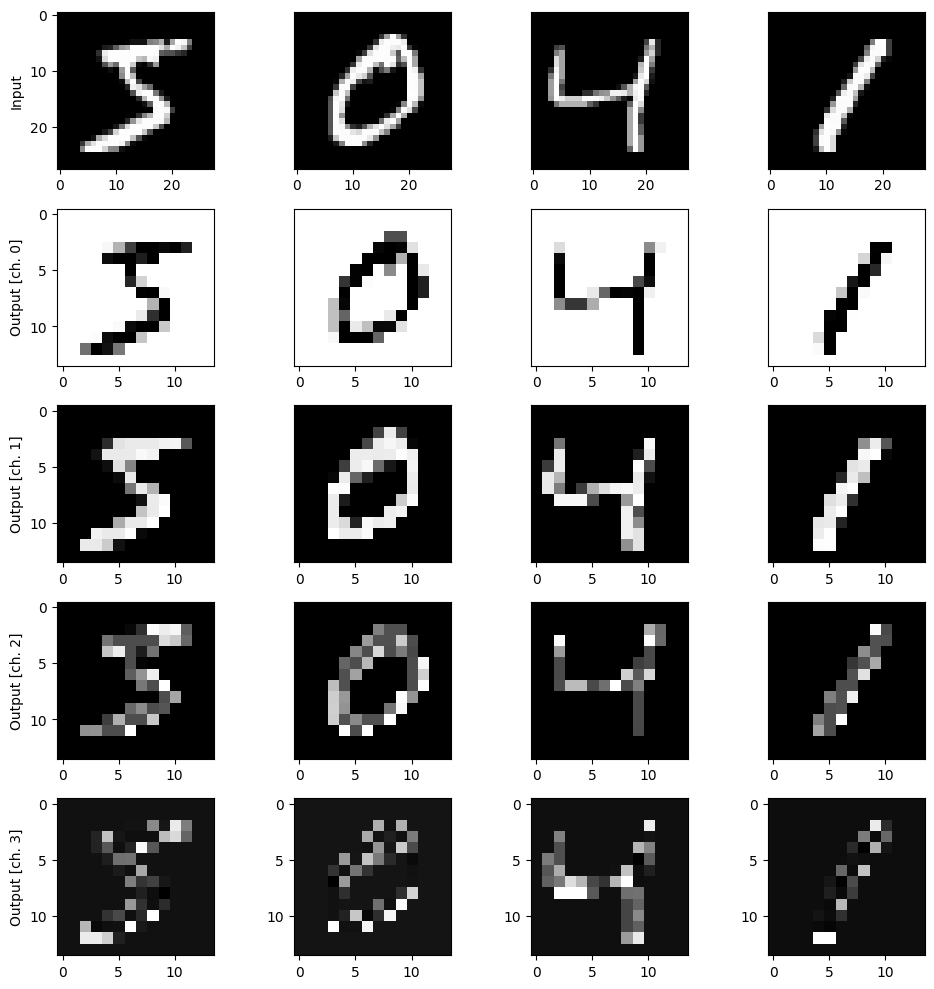

In [12]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

### Hybrid quantum-classical model

After the application of the quantum convolution layer we feed the resulting features into a classical neural network that will be trained to classify the 10 different digits of the MNIST dataset.

Just a fully connected layer with 10 output nodes with a final softmax activation function.

The model is compiled with a stochastic-gradient-descent optimizer, and a cross-entropy loss function.

In [13]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

### Training

We first initialize an instance of the model, then we train and validate it with the dataset that has been already pre-processed by a quantum convolution.

In [14]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 2s - 116ms/step - accuracy: 0.1400 - loss: 2.8198 - val_accuracy: 0.2333 - val_loss: 2.1249
Epoch 2/30
13/13 - 0s - 15ms/step - accuracy: 0.3600 - loss: 1.9855 - val_accuracy: 0.3333 - val_loss: 1.9690
Epoch 3/30
13/13 - 0s - 21ms/step - accuracy: 0.4400 - loss: 1.6954 - val_accuracy: 0.4000 - val_loss: 1.8235
Epoch 4/30
13/13 - 0s - 9ms/step - accuracy: 0.6000 - loss: 1.3911 - val_accuracy: 0.5000 - val_loss: 1.6689
Epoch 5/30
13/13 - 0s - 6ms/step - accuracy: 0.7200 - loss: 1.1531 - val_accuracy: 0.6000 - val_loss: 1.5636
Epoch 6/30
13/13 - 0s - 11ms/step - accuracy: 0.9000 - loss: 0.9696 - val_accuracy: 0.6000 - val_loss: 1.4862
Epoch 7/30
13/13 - 0s - 11ms/step - accuracy: 0.9400 - loss: 0.8169 - val_accuracy: 0.6000 - val_loss: 1.4168
Epoch 8/30
13/13 - 0s - 5ms/step - accuracy: 0.9400 - loss: 0.6949 - val_accuracy: 0.6333 - val_loss: 1.3592
Epoch 9/30
13/13 - 0s - 6ms/step - accuracy: 0.9400 - loss: 0.5950 - val_accuracy: 0.6333 - val_loss: 1.3141
Epoch 10/30
1

In order to compare the results achievable with and without the quantum convolution layer, we initialize also a “classical” instance of the model that will be directly trained and validated with the raw MNIST images (i.e., without quantum pre-processing).

In [15]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 67ms/step - accuracy: 0.1000 - loss: 2.3097 - val_accuracy: 0.2333 - val_loss: 2.1254
Epoch 2/30
13/13 - 0s - 10ms/step - accuracy: 0.4800 - loss: 1.9145 - val_accuracy: 0.3000 - val_loss: 2.0133
Epoch 3/30
13/13 - 0s - 13ms/step - accuracy: 0.6800 - loss: 1.6376 - val_accuracy: 0.3667 - val_loss: 1.8997
Epoch 4/30
13/13 - 0s - 6ms/step - accuracy: 0.7400 - loss: 1.4079 - val_accuracy: 0.4667 - val_loss: 1.7889
Epoch 5/30
13/13 - 0s - 10ms/step - accuracy: 0.8600 - loss: 1.2155 - val_accuracy: 0.4667 - val_loss: 1.6894
Epoch 6/30
13/13 - 0s - 11ms/step - accuracy: 0.8800 - loss: 1.0551 - val_accuracy: 0.5000 - val_loss: 1.6048
Epoch 7/30
13/13 - 0s - 7ms/step - accuracy: 0.9400 - loss: 0.9214 - val_accuracy: 0.5333 - val_loss: 1.5344
Epoch 8/30
13/13 - 0s - 6ms/step - accuracy: 0.9600 - loss: 0.8096 - val_accuracy: 0.5333 - val_loss: 1.4755
Epoch 9/30
13/13 - 0s - 7ms/step - accuracy: 0.9800 - loss: 0.7154 - val_accuracy: 0.6333 - val_loss: 1.4256
Epoch 10/30
13

### Results

We can finally plot the test accuracy and the test loss with respect to the number of training epochs.

<ipython-input-16-c3ef9ba498fb>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


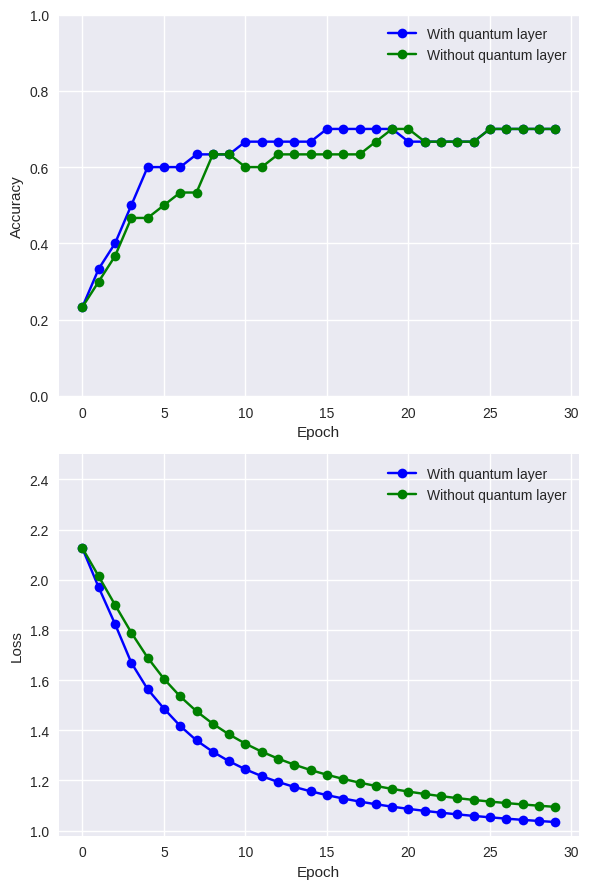

In [16]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()